# Merge NSF Survey of Earned Doctorates Spreadsheets
J. Nathan Matias

Last updated Feb 5, 2022

This dataset includes citizens and permanent residents

* Asian Includes Native Hawaiians or Other Pacific Islanders through 2000, but excludes them since 2001.
* Before 2001, "Other race or race not reported" included respondents who selected more than one race. Since 2001, this category has included Native Hawaiians or Other Pacific Islanders, who previously had been included in the category Asian.
* Life Sciences Includes agricultural sciences and natural resources; biological and biomedical sciences; and health sciences.
* Field (Other) Includes other non-science and engineering fields not shown separately
* All groups other than "Hispanic or Latino" are classified as "Not Hispanic or Latino"

In [293]:
from openpyxl import load_workbook
import pandas as pd
from collections import defaultdict, Counter
import datetime
import csv
import matplotlib.pyplot as plt

In [294]:
data_path = "/Users/nathan/Box/Projects/"
nsed_path = "2021-NSF-Survey-Earned-Doctorates/"
nces_path = "2021-NCES-Faculty-Data/"
nces_generation_date ="20220109"



year_filenames = {
    "2016": "tab23-2016.xlsx",
    "2017": "sed17-sr-tab023-2017.xlsx",
    "2018": "nsf20301-tab023-2018.xlsx",
    "2019": "nsf21308-tab023-2019.xlsx",
    "2020": "nsf22300-tab023-2020.xlsx"  
}

fields = ["All fields",
          "Life sciencesc", 
          "Physical sciences and earth sciences", 
          "Mathematics and computer sciences",
          "Psychology and social sciences",
          "Engineering",
          "Education",
          "Humanities and arts",
          "Otherd"]

### Utility method for generating year rows from the NSF Earned Doctorates Workbook

In [295]:
def generate_year_rows(wb):

    counter = 0

    # dict with the index as key
    # and the column name as the value
    colnames = {}

    ## data structure for storing records:
    ## one row per field + group + year
    ## field, group, year, count
    records = []

    field = None
    group = None


    for row in wb.worksheets[0].values:
        # the first three rows are labels
        if(counter<3): 
            counter += 1
            continue

        ## the end of the sequence
        if(row[0] is None):
            break

        ## header row
        if(counter==3):
            i = 0
            for colname in row:
                if colname is None:
                    continue
                colnames[i] = colname
                i += 1
            counter += 1
            continue
            
        ## skip rows labeled "Not Hispanic or Latino"
        if row[0].strip() == "Not Hispanic or Latino":
            counter += 1
            continue

        if row[0].strip() in fields:
            group = "Total"
            field = row[0].strip()
        else:
            group = row[0].strip()

        ## add record
        for i in range(1, len(colnames)):
            year = colnames[i]
            records.append({
                "field": field,
                "group": group,
                "year" : int(year),
                "count": row[i]
            })

        counter += 1
    return records

In [296]:
all_records = []

for year_filename in year_filenames.values():
    print(year_filename)
    wb = load_workbook(data_path + nsed_path + year_filename)
    all_records += generate_year_rows(wb)

tab23-2016.xlsx
sed17-sr-tab023-2017.xlsx
nsf20301-tab023-2018.xlsx


/usr/local/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


nsf21308-tab023-2019.xlsx
nsf22300-tab023-2020.xlsx


# Validate Records
* Field-level records should add up to the "All Fields" count for each group (done)
* Totals should add up for each group

In [297]:
all_groups = list(set([x['group'] for x in all_records]))
all_fields = list(set([x['field'] for x in all_records]))
all_years = list(set([x['year'] for x in all_records]))
#all_fields
#all_records[0]

for year in all_years:
#    print(year)
    for group in all_groups:
        all_fields_total = [x for x in all_records 
                            if x['group'] == group
                            and x['field'] == "All fields"
                            and x['year'] == year][0]['count']
        if(all_fields_total=="na"):
            all_fields_total = 0
        
        field_record_total = 0
        for field_record in [x for x in all_records if 
                          x['field']!="All fields"
                          and x['group'] == group
                          and x['year'] == year and x['count']!='na']:
            field_record_total += field_record['count']
        
        if(field_record_total!=all_fields_total):
            print("{0} {1}: {2} != {3}".format(group, year, all_fields_total, field_record_total))
        assert(field_record_total == all_fields_total)

In [298]:
# [x for x in all_records if x['year']==2000 and x['group']=="Hispanic or Latino" and x['field']=="Mathematics and computer sciences"]
# [x for x in all_records if x['year']==2000 and x['group']=="Hispanic or Latino"]

# Write Output to file

In [299]:
min_year = str(min([x['year'] for x in all_records]))
max_year = str(max([x['year'] for x in all_records]))
timestamp_str = datetime.datetime.now().strftime("%Y%m%d")
pd.DataFrame(all_records).to_csv(data_path + nsed_path + "nsf_earned_doctorate_race_ethnicity_years_" +
                                 min_year + "-" + max_year + "_" + timestamp_str + ".csv", index=False)

# Generate the Difference Between Hiring Rates and PhD Conferral Rates
Simple formula:

Notes:
* Assuming an average time to tenure of 7 years, we estimate the number of faculty hired in the previous year to be this year's number of un-tenured TT faculty ÷ 7
  *  Note that since URM faculty often move between institutions more often, this number might be smaller yet, since this model assumes 7 years to tenure on average. Time to tenure is also longer for women on average.

Caveats:
* Some PhDs go into non-TT positions and positions in industry, which we do not consider here. This analysis does not consider the reasons why people go into other kinds of jobs—it just documents the limitations of the pipeline analogy when the real issue is the capacity of institutions to attract qualified candidates and their unwillingness to hire them.

In [300]:
years_to_tenure = 7
years_after_phd = 5


nces_rows = []
with open (data_path + nces_path + nces_generation_date +  "_year_summary_table.csv") as f:
    for row in DictReader(f):
        nces_rows.append(row)

nces_min_year = min([int(x['year']) for x in nces_rows])

In [301]:
## create un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_sum

for row in nces_rows:
    row['un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_sum'] = \
    int(row['un_tenured_American_Indian_or_Alaska_Native_total_sum']) + \
    int(row['un_tenured_Black_or_African_American_total_sum']) +        \
    int(row['un_tenured_Hispanic_or_Latino_total_sum']) +               \
    int(row['un_tenured_Native_Hawaiian_or_Other_Pacific_Islander_total_sum']) + \
    int(row['un_tenured_Two_or_more_races_total_sum'])
    
    ## add row estimating the number of new junior faculty hired in the previous year
    ## and added to the rolls this year, rounded to the closest integer
    ## on the assumption that tenure takes seven years on average 
    
    row['new_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_sum'] =  \
       round(row['un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_sum']/years_to_tenure)

#### Generate Simulated Year Totals for Earned Doctorates
Generate simulated year totals and cumulative totals.

Generated these simulated year totals and cumulative totals starting four year before the NCES records start, on the view that people are hired into faculty jobs within **five years** of completing their PhD (especially after a postdoc).

In [302]:

## create a dict of year rows, with cumulative counts
def year_row():
    return {
        "year":None,
        "year_total": 0,
        "prev_year_total": None,
        "cur_year_total": None
    }

field_count = len(set([x['field'] for x in all_records]))-1
field_graduates = defaultdict(year_row)

# observed totals
for year_row in sorted([x for x in all_records 
                        if x['field'] =="All fields" and \
                           x['group'] in ['Hispanic or Latino', 'American Indian or Alaska Native',
                                          'Black or African American', 'More than one race'] and
                           x['year']>=nces_min_year - years_after_phd
                       ], 
                       key = lambda x: x['year']):    
    if(year_row['count']!="na"):
        field_graduates[year_row['year']]['year'] = year_row['year']
        field_graduates[year_row['year']]['year_total'] += int(year_row['count'])

In [303]:
## now generate cumulative totals per year

In [304]:
min_year = min([x['year'] for x in field_graduates.values()])
max_year = max([x['year'] for x in field_graduates.values()])

prev_year_total = None
for year in range(min_year, max_year + 1):
    field_graduates[year]['prev_year_total'] = prev_year_total
    
    if(prev_year_total is None):
        prev_year_total = 0
    
    field_graduates[year]['cur_year_total']  = prev_year_total + field_graduates[year]['year_total']
    prev_year_total += field_graduates[year]['year_total']

In [305]:
#field_graduates

#### Merge per-year simulations into NCES data
* add `total_hired_prev_year`, the estimated total number of URM faculty hired in the previous year. By being based on the totals across higher education, it  is not sensitive to between-institution factors.
* add `pct_hired_prev_year_pipeline`, which is the estimated percent of URM faculty hired in the previous year, as a proportion of simulated lower bound of faculty who finished their PhDs just that year. The purpose of this is to reproduce the commonly-held pipeline stereotype.
* add `cumulative_hires_prev_year`, the cumuliative total of URM faculty who were hired up to the previous year, starting with the job market the year before the NCES data. 
* add `cumulative_unhired_prev_year`, the simulated minimum total number of URM faculty who weren't hired in the previous year, starting with the job market year one year before the current NCES data, assuming all fields produce and hire as few URM faculty as math/cs.

In [306]:
cumulative_hired_prev_year = 0

for year_row in sorted(nces_rows, key=lambda x: int(x['year'])):
    year = int(year_row['year'])
    
    ## job market year
    market_year = year - 1
    year_row['market_year'] = market_year

    ## PhD URM graduates in the previous year
    prev_year_field_graduates = field_graduates[market_year]
    year_row['prev_year_field_graduates'] = prev_year_field_graduates['cur_year_total']
    
    total_hired_prev_year = year_row['new_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_sum']
    
    cumulative_hired_prev_year += total_hired_prev_year
    year_row['cumulative_hired_prev_year'] = cumulative_hired_prev_year
    
    cumulative_unhired_prev_year = prev_year_field_graduates['cur_year_total'] - cumulative_hired_prev_year
    year_row['cumulative_unhired_prev_year'] = cumulative_unhired_prev_year

    
#     print("\n")
#     print(year)
#     print("Among Total PhDs:")
#     print("  {0} hired prev year".format(total_hired_prev_year))
#     print("  {0} new available last year ".format(prev_year_field_graduates['year_total']))
#     print("  {0} cumulative available since {1}".format(prev_year_field_graduates['cur_year_total'], nces_min_year - years_after_phd))
#     print("  {0} cumulative hires since {1}".format(cumulative_hires_prev_year, nces_min_year - years_after_phd))
#     print("  {0} cumulative non-hires since {1}".format(cumulative_unhired_prev_year, nces_min_year - years_after_phd))

Text(0.5, 1.0, 'Number of available URM PhDs not employed in TT positions in the US by year')

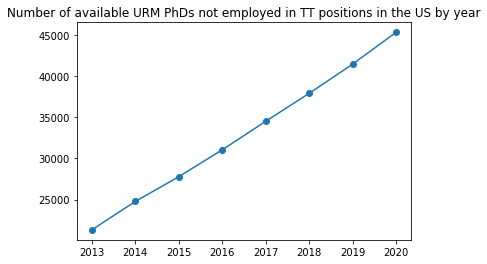

In [307]:
nces_rows = sorted(nces_rows, key=lambda x: x['year'])
plt.scatter([x['year'] for x in nces_rows], 
         [x['cumulative_unhired_prev_year'] for x in nces_rows])
plt.plot([x['year'] for x in nces_rows], 
         [x['cumulative_unhired_prev_year'] for x in nces_rows])
plt.title("Number of available URM PhDs not employed in TT positions in the US by year")

## Write to File

In [308]:
pd.DataFrame(nces_rows).to_csv(data_path + nces_path + timestamp_str + "_nces_unhired_simulation" + ".csv", index=False)